In [2]:
!pip install -U langchain-community
!pip install protobuf==3.20.3 googleapis-common-protos==1.56.4 --force-reinstall
!pip install -q faiss-cpu --upgrade
!pip install -q langchain transformers sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.0/475.0 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.7/343.7 kB 23.4 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.72
    Uninstalling langchain-core-0.3.72:
      Successfully uninstalled langchain-core-0.3.72
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.9
    Uninstalling langchain-text-splitters-0.3.9:
      Successfully uninstalled langchain-text-splitters-0.3.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.1.

In [3]:
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt
import datasets
import torch
from tqdm.notebook import tqdm 
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
import os
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, pipeline
from transformers import pipeline, AutoModelForCausalLM, BitsAndBytesConfig

from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter, TokenTextSplitter
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain_community.llms import HuggingFacePipeline

import networkx as nx
from collections import defaultdict
import pickle

2025-12-07 14:25:27.738221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765117527.937613      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765117527.995108      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
### Dataset loading

#ds = datasets.load_dataset("wikimedia/wikipedia", "20231101.en", split="train")
ds = datasets.load_dataset("wikimedia/wikipedia", "20231101.simple", split="train")

### Visualize data in the documents
print(ds)
print(ds['title'][0])
print(ds['text'][0])

README.md: 0.00B [00:00, ?B/s]

20231101.simple/train-00000-of-00001.par(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/241787 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'url', 'title', 'text'],
    num_rows: 241787
})
April
April (Apr.) is the fourth month of the year in the Julian and Gregorian calendars, and comes between March and May. It is one of the four months to have 30 days.

April always begins on the same day of the week as July, and additionally, January in leap years. April always ends on the same day of the week as December.

The Month 

April comes between March and May, making it the fourth month of the year. It also comes first in the year out of the four months that have 30 days, as June, September and November are later in the year.

April begins on the same day of the week as July every year and on the same day of the week as January in leap years. April ends on the same day of the week as December every year, as each other's last days are exactly 35 weeks (245 days) apart.

In common years, April starts on the same day of the week as October of the previous year, and in leap years, May of the previou

In [5]:
### Store documents in langchain framework

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"title": doc.get("title", None),"url": doc.get("url", None),})
    for doc in tqdm(ds)
]

  0%|          | 0/241787 [00:00<?, ?it/s]

Preprocessing the data 

In [6]:
# Hierarchical list of separators for splitting Markdown documents
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",        # Markdown headings (#, ##, ..., ######)
    "```\n",            # backtick codeblocks (```)
    "\n\\*\\*\\*+\n",   # asterisks (***)
    "\n---+\n",         # Dashes (---)
    "\n___+\n",         # Underscore (___)
    "\n\n",             # Double newline
    "\n",               # Single newline
    " ",                # Spaces. If text is still too large, it will try splitting at spaces (i.e., word boundaries).
    "",                 # individual characters. The final and smallest level. If no separator fits, it will just split by character count.
]

With the information obtained from MTEB huggingface site and with respect to our requirements and hardware availability, we decided to process with E5-base-v2 model or bge-base-en-v1.5 model. 
E5-base-v2 - uses 418MB memory, trained with 109M parameters. Its Embedding dimension is 768 and max tokens is 512 (This decided our chunk size)
bge-base-en-v1.5 has is also trained with 109M params, with embedding dimension as 768 and max tokens in 512. 

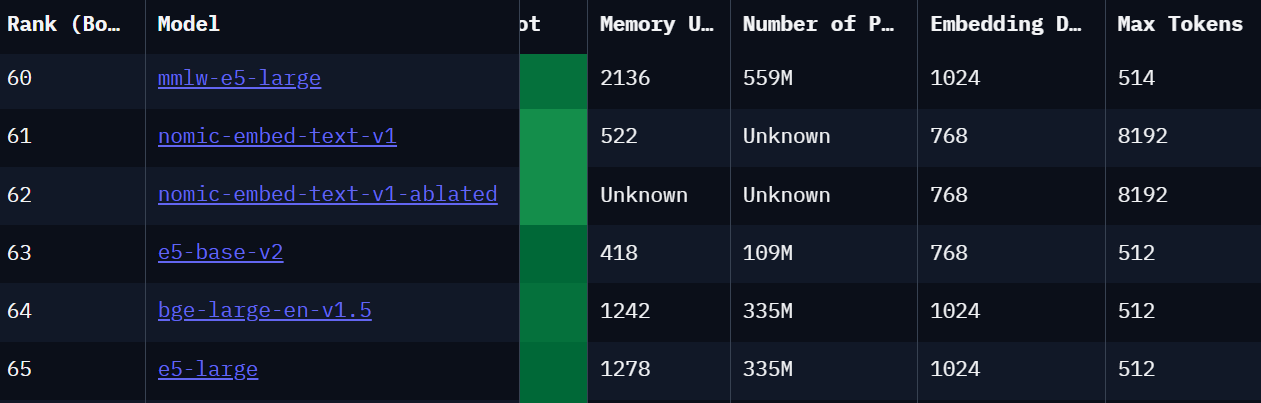

In [7]:
# Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.

EMBEDDING_MODEL_NAME = "intfloat/e5-small-v2"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:

    text_splitter = TokenTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        # separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicate document contents (if any)
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique
    


docs_processed = split_documents(
    480,
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)



tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [8]:
# Initialize the embedding model using Hugging Face
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,        # Name of the embedding model to use (Here, gte-small)                  # Enables multi-processing for faster embedding generation
    model_kwargs={"device": "cuda"},        # Runs the model on GPU for better performance
    encode_kwargs={"normalize_embeddings": True},  # Normalizes embeddings for cosine similarity calculations
)

/tmp/ipykernel_47/2527892850.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

  0%|          | 0/319854 [00:00<?, ?it/s]

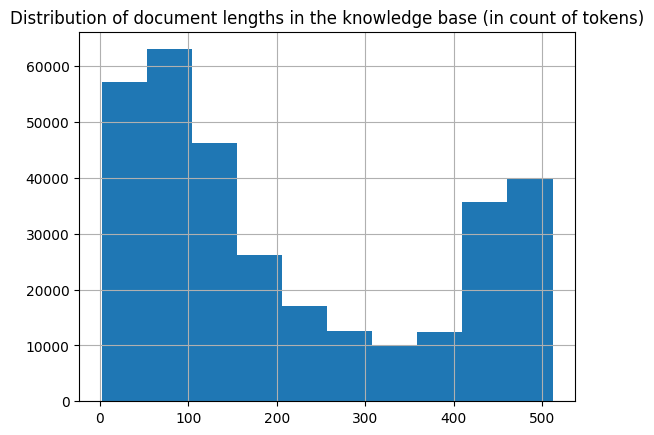

In [9]:
# Let's visualize the chunk sizes we would have in tokens
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content, truncation=True, max_length=512)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [10]:
# Use GPU if available else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔹 Using device: {device}")

# Load the embedding model
EMBEDDING_MODEL_NAME = "intfloat/e5-small-v2" 

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    model_kwargs={"device": device},
    encode_kwargs={"normalize_embeddings": True},
)

print("Embedding model loaded successfully.")

# Embed the data
texts = [doc.page_content for doc in docs_processed]
metadatas = [doc.metadata for doc in docs_processed]
print(f"🔹 Total documents to embed: {len(texts)}")

BATCH_SIZE = 64 if device == "cuda" else 8  # safer for 16GB GPU
print(f"🔹 Using batch size: {BATCH_SIZE}")

all_embeddings = []
for i in tqdm(range(0, len(texts), BATCH_SIZE), desc=f"Embedding batches ({device.upper()})"):
    batch_texts = texts[i : i + BATCH_SIZE]
    batch_embeddings = embedding_model.embed_documents(batch_texts)
    all_embeddings.extend(batch_embeddings)

print("Embeddings created successfully.")

# Storing data in FAISS DB 
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_embeddings(
    zip(texts, all_embeddings),
    embedding_model,
    metadatas=metadatas,
    distance_strategy=DistanceStrategy.COSINE, 
)

print("FAISS vector database created successfully.")

# Saving the FAISS index
os.makedirs("artifacts", exist_ok=True)
KNOWLEDGE_VECTOR_DATABASE.save_local("artifacts/faiss_index_e5_small")
print("Saved FAISS index at: artifacts/faiss_index_e5_small")


🔹 Using device: cuda
Embedding model loaded successfully.
🔹 Total documents to embed: 319854
🔹 Using batch size: 64


Embedding batches (CUDA):   0%|          | 0/4998 [00:00<?, ?it/s]

Embeddings created successfully.
FAISS vector database created successfully.
Saved FAISS index at: artifacts/faiss_index_e5_small


In [11]:
!zip -r faiss_index_e5_small.zip artifacts/faiss_index_e5_small 

  adding: artifacts/faiss_index_e5_small/ (stored 0%)
  adding: artifacts/faiss_index_e5_small/index.pkl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 66%)
  adding: artifacts/faiss_index_e5_small/index.faiss (deflated 8%)


In [13]:
!ls -R artifacts/faiss_index_e5_small

artifacts/faiss_index_e5_small:
index.faiss  index.pkl


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [72]:
#Knowledge graph visualization
import spacy
nlp = spacy.load("en_core_web_sm")
# Initialize graph
G = nx.DiGraph()
entity_freq = defaultdict(int)

sample_size = min(500, len(docs_processed))
sample_docs = docs_processed[:sample_size]

for doc in tqdm(sample_docs, desc="Building Knowledge Graph"):
    text = doc.page_content
    spacy_doc = nlp(text)
    
    # Extract named entities
    entities = [(ent.text.strip(), ent.label_) for ent in spacy_doc.ents 
                if len(ent.text.strip()) > 2]
    
    # Add entities as nodes
    for ent_text, ent_type in entities:
        entity_freq[ent_text] += 1
        if G.has_node(ent_text):
            G.nodes[ent_text]['frequency'] += 1
        else:
            G.add_node(ent_text, entity_type=ent_type, frequency=1)
    
    # Build relationships
    for sent in spacy_doc.sents:
        sent_ents = [(ent.text.strip(), ent.label_) for ent in sent.ents 
                     if len(ent.text.strip()) > 2]
        
        for i in range(len(sent_ents)):
            for j in range(i + 1, len(sent_ents)):
                entity1, type1 = sent_ents[i]
                entity2, type2 = sent_ents[j]
                
                if G.has_edge(entity1, entity2):
                    G[entity1][entity2]['weight'] += 1
                else:
                    G.add_edge(entity1, entity2, 
                              relation='co_occurs',
                              weight=1,
                              source_type=type1,
                              target_type=type2)

# Filter noise
MIN_FREQUENCY = 2
nodes_to_remove = [node for node, data in G.nodes(data=True) 
                   if data.get('frequency', 0) < MIN_FREQUENCY]
G.remove_nodes_from(nodes_to_remove)

print(f" Knowledge Graph Created:")
print(f"   • Nodes: {len(G.nodes())}")
print(f"   • Edges: {len(G.edges())}")

# Save graph
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/knowledge_graph.pkl", "wb") as f:
    pickle.dump(G, f)

Building Knowledge Graph:   0%|          | 0/500 [00:00<?, ?it/s]

 Knowledge Graph Created:
   • Nodes: 1704
   • Edges: 11973


In [73]:
def query_knowledge_graph(query_entities, G, max_hops=2):
    """Extract relevant subgraph for query entities"""
    relevant_nodes = set()
    
    for entity in query_entities:
        matching_nodes = [n for n in G.nodes() 
                         if entity.lower() in n.lower() or n.lower() in entity.lower()]
        
        for node in matching_nodes:
            relevant_nodes.add(node)
            try:
                neighbors = nx.single_source_shortest_path_length(G, node, cutoff=max_hops)
                relevant_nodes.update(neighbors.keys())
            except:
                pass
    
    subgraph = G.subgraph(relevant_nodes)
    return subgraph, list(relevant_nodes)

In [74]:
def plot_kg_subgraph(subgraph, query_entities=None, title="Knowledge Graph Subgraph"):
    """
    Visualize the subgraph returned by query_knowledge_graph.
    
    - subgraph: graph returned by query_knowledge_graph
    - query_entities: list of original entity strings (used to highlight nodes)
    """
    if subgraph.number_of_nodes() == 0:
        print("Subgraph is empty. Nothing to plot.")
        return

    plt.figure(figsize=(8, 6))

    # Layout for nodes
    pos = nx.spring_layout(subgraph, k=0.6, seed=42)

    # Color nodes: highlight those matching query entities
    node_colors = []
    for node in subgraph.nodes():
        if query_entities and any(
            e.lower() in node.lower() or node.lower() in e.lower()
            for e in query_entities
        ):
            node_colors.append("tab:red")   # nodes related to query
        else:
            node_colors.append("tab:blue")  # other nodes in neighborhood

    nx.draw_networkx_nodes(
        subgraph,
        pos,
        node_color=node_colors,
        node_size=700,
        alpha=0.9,
    )
    nx.draw_networkx_edges(
        subgraph,
        pos,
        alpha=0.6,
        arrows=True,
        arrowstyle="->",
        min_source_margin=10,
        min_target_margin=10,
    )
    nx.draw_networkx_labels(
        subgraph,
        pos,
        font_size=8,
        font_weight="bold",
    )

    # Optional: show edge labels if you stored relation in "label" or "relation"
    # edge_labels = {}
    # for u, v, data in subgraph.edges(data=True):
    #     label = data.get("label") or data.get("relation")
    #     if label:
    #         edge_labels[(u, v)] = label

    # if edge_labels:
    #     nx.draw_networkx_edge_labels(
    #         subgraph,
    #         pos,
    #         edge_labels=edge_labels,
    #         font_size=7,
    #     )

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


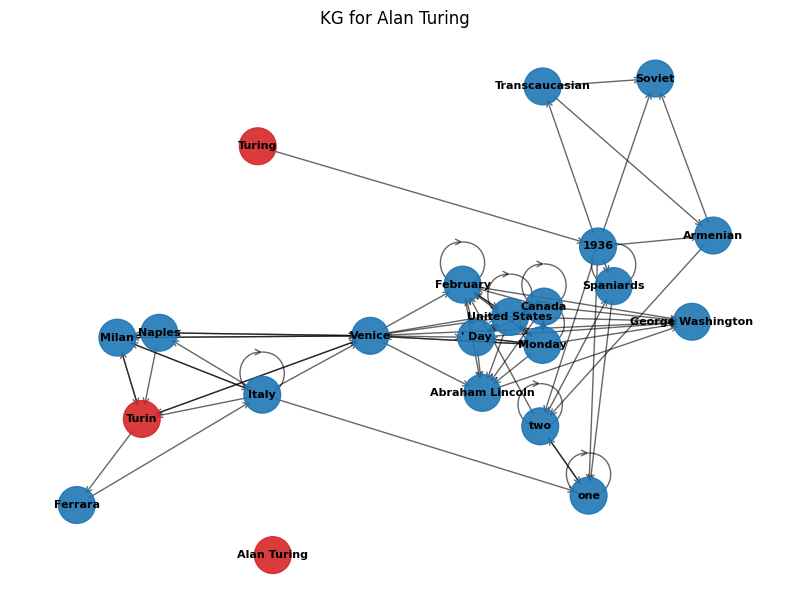

In [75]:
#Example knowledge graph visualization
query_entities = ["Alan Turing"] 
subgraph, relevant_nodes = query_knowledge_graph(query_entities, G)
plot_kg_subgraph(subgraph, query_entities=query_entities, title="KG for Alan Turing")


In [59]:
# RAG process
#Step - 1 Loading Flan-t5-small model

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f" Using device: {device}")

MODEL_NAME = "google/flan-t5-small"

print(f" Loading {MODEL_NAME}...")
flan_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
flan_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
flan_model = flan_model.to(device)
print(f" Model loaded on {device}")


 Using device: cuda
 Loading google/flan-t5-small...
 Model loaded on cuda


In [20]:
# Step - 2 Querying
def flan_rag_query(query, k=5, use_kg=True, verbose=True):
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"🔍 Query: {query}")
        print(f"{'='*60}")
    
    # Step 1: Retrieve from FAISS
    if verbose:
        print(f"Retrieving top-{k} documents...")
    
    retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query, k=k)
    
    context_parts = []
    for i, doc in enumerate(retrieved_docs, 1):
        context_parts.append(f"Document {i}: {doc.page_content}")
    
    context = "\n\n".join(context_parts)
    
    # Step 2: Knowledge Graph Enhancement
    kg_context = ""
    if use_kg:
        if verbose:
            print("Querying knowledge graph...")
        
        query_doc = nlp(query)
        query_entities = [ent.text for ent in query_doc.ents]
        
        if query_entities:
            subgraph, relevant_nodes = query_knowledge_graph(query_entities, G)
            
            if len(relevant_nodes) > 0:
                kg_info = f"Related entities: {', '.join(relevant_nodes[:10])}"
                edges = list(subgraph.edges(data=True))[:5]
                if edges:
                    relations = [f"{e[0]} → {e[1]}" for e in edges]
                    kg_info += f"\nRelationships: {'; '.join(relations)}"
                
                kg_context = f"\n\nKnowledge Graph:\n{kg_info}"
                if verbose:
                    print(f"   Found {len(relevant_nodes)} related entities")
    
    # Step 3: Generate with FLAN-T5
    if verbose:
        print("Generating answer...")
    
    prompt = f"""Answer the question based on the context.

Context:
{context}{kg_context}

Question: {query}

Answer:"""
    
    # Tokenize
    inputs = flan_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Generate
    with torch.no_grad():  
        outputs = flan_model.generate(
            **inputs,
            max_length=150,
            num_beams=4,
            early_stopping=True,
            temperature=0.7,
            do_sample=False
        )
    
    answer = flan_tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Display results
    if verbose:
        print(f"\n{'='*60}")
        print(f"ANSWER: {answer}")
        print(f"{'='*60}")
        print(f"\n Source Documents:")
        for i, doc in enumerate(retrieved_docs, 1):
            print(f"\n[{i}] {doc.page_content[:150]}...")
    
    return {
        'answer': answer,
        'retrieved_docs': retrieved_docs,
        'context': context,
        'kg_context': kg_context
    }

In [21]:
# Step - 3 Testing with Sample Queries
test_queries = [
    "What is artificial intelligence?",
    "Who invented the telephone?",
    "What is machine learning?",
    "What do you know about Alan Turing?"
]

results = []
for query in test_queries:
    result = flan_rag_query(query, k=3, use_kg=True)
    results.append(result)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



🔍 Query: What is artificial intelligence?
Retrieving top-3 documents...
Querying knowledge graph...
Generating answer...


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



ANSWER: intelligent machines are more likely to be able to learn.

 Source Documents:

[1] Artificial intelligence is a sub-discipline of computer science. AI tries to allow computers to mimic human intelligence in order to solve complex pro...

[2] Artificial intelligence (AI) is the ability of a computer program or a machine to think and learn. It is a field of study which tries to make computer...

[3] Artificial intelligence in healthcare refers to the integration of advanced computer algorithms and machine learning techniques into the field of heal...

🔍 Query: Who invented the telephone?
Retrieving top-3 documents...
Querying knowledge graph...
Generating answer...


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



ANSWER: Using a telephone, two people who are in different places can talk to each other.

 Source Documents:

[1] The photophone is a telecommunications device that allows transmission of speech on a beam of light. It was invented by Alexander Graham Bell along wi...

[2] A telephone, also known as a phone, is a communication tool. People use it to talk with people far away. Originally, it was an electric tool sending a...

[3] Antonio Meucci (Florence, April 13, 1808 – October 18, 1889) was an Italian inventor. He invented the first type of telephone, also known as the first...

🔍 Query: What is machine learning?
Retrieving top-3 documents...
Querying knowledge graph...
Generating answer...

ANSWER: machine learning program

 Source Documents:

[1] In machine learning, supervised learning is the task of inferring a function from labelled training data. The results of the training are known before...

[2] Machine learning gives computers the ability to learn without being explicitly 

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Querying knowledge graph...
   Found 52 related entities
Generating answer...

ANSWER: Ethel Sara Stoney

 Source Documents:

[1] Turing may refer to:

 Alan Turing, a computer scientist
 Turing test, a test to see if a computer can act like a person
 Turing machine, an idea in c...

[2] The Turing test is a test to see if a computer can interact with a person. The human should not be able to realise it is interacting with a computer. ...

[3] Alan Mathison Turing OBE FRS (London, 23 June 1912 – Wilmslow, Cheshire, 7 June 1954) was an English mathematician and computer scientist. He was born...


In [22]:
# Step - 1 Loading TinyLlama model

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

print(f"Loading {MODEL_NAME}...")

# Tokenizer
tiny_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

if tiny_tokenizer.pad_token is None:
    tiny_tokenizer.pad_token = tiny_tokenizer.eos_token
tiny_tokenizer.padding_side = "left"  # better for batched generation

# Model 
#TIny Llama is not a seq2seq model, CausalLM transformer is used

tiny_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
)
tiny_model.to(device)
tiny_model.eval()

print(f"Model loaded on {device}")


Using device: cuda
Loading TinyLlama/TinyLlama-1.1B-Chat-v1.0...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded on cuda


In [23]:
# Step - 2 Querying
def tiny_rag_query(query, k=5, use_kg=True, verbose=True, max_new_tokens=256):
    """Complete RAG pipeline using TinyLlama causal LM."""
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"Query: {query}")
        print(f"{'='*60}")
    
    # Step 1: Retrieve from FAISS
    if verbose:
        print(f"Retrieving top-{k} documents...")
    
    retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query, k=k)
    
    context_parts = []
    for i, doc in enumerate(retrieved_docs, 1):
        context_parts.append(f"Document {i}: {doc.page_content}")
    
    context = "\n\n".join(context_parts) if context_parts else "No relevant documents found."
    
    # Step 2: Knowledge Graph Enhancement (optional)
    kg_context = ""
    if use_kg:
        if verbose:
            print("Querying knowledge graph...")
        
        query_doc = nlp(query)
        query_entities = [ent.text for ent in query_doc.ents]
        
        if query_entities:
            subgraph, relevant_nodes = query_knowledge_graph(query_entities, G)
            
            if len(relevant_nodes) > 0:
                kg_info = f"Related entities: {', '.join(relevant_nodes[:10])}"
                
                edges = list(subgraph.edges(data=True))[:5]
                if edges:
                    relations = [f"{e[0]} → {e[1]}" for e in edges]
                    kg_info += f"\nRelationships: {'; '.join(relations)}"
                
                kg_context = f"\n\nKnowledge Graph:\n{kg_info}"
                
                if verbose:
                    print(f"   Found {len(relevant_nodes)} related entities")
            elif verbose:
                print("   No related entities found in KG.")
        elif verbose:
            print("   No entities detected in query for KG.")
    
    # Step 3: Generate with TinyLlama (causal LM)
    if verbose:
        print("Generating answer with TinyLlama...")
    
    prompt = f"""You are a helpful and concise assistant. 
Use the context and knowledge graph information to answer the question. 
If the answer cannot be found, say you are not sure.

Context:
{context}{kg_context}

Question: {query}

Answer:"""
    
    # Tokenize prompt
    inputs = tiny_tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=1024,  # limit input length to avoid OOM
        padding=False,
    ).to(device)
    
    # Generate continuation
    with torch.no_grad():
        outputs = tiny_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            top_p=0.9,
            temperature=0.7,
            pad_token_id=tiny_tokenizer.pad_token_id,
            eos_token_id=tiny_tokenizer.eos_token_id,
        )
    
    # Decode only the newly generated tokens (after the prompt)
    generated_ids = outputs[0][inputs["input_ids"].shape[1]:]
    answer = tiny_tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
    
    # Step 4: Display results
    if verbose:
        print(f"\n{'='*60}")
        print(f"ANSWER: {answer}")
        print(f"{'='*60}")
        print(f"\nSource Documents:")
        for i, doc in enumerate(retrieved_docs, 1):
            print(f"\n[{i}] {doc.page_content[:150]}...")
    
    return {
        "answer": answer,
        "retrieved_docs": retrieved_docs,
        "context": context,
        "kg_context": kg_context,
        "prompt": prompt,
    }


In [24]:
# Step - 3 Testing with Sample Queries
test_queries = [
    "What is artificial intelligence?",
    "Who invented the telephone?",
    "What is machine learning?",
    "What do you know about Alan Turing?"
]

results = []
for query in test_queries:
    result = tiny_rag_query(query, k=3, use_kg=True)
    results.append(result)



Query: What is artificial intelligence?
Retrieving top-3 documents...
Querying knowledge graph...
   No entities detected in query for KG.
Generating answer with TinyLlama...

ANSWER: Artificial intelligence is a field of study that aims to make computers "smart" by mimicking human intelligence. It involves using computer algorithms and machine learning techniques to analyze and understand complex data. In healthcare, AI is used to analyze medical data, make predictions, diagnose diseases, and recommend treatment plans.

Source Documents:

[1] Artificial intelligence is a sub-discipline of computer science. AI tries to allow computers to mimic human intelligence in order to solve complex pro...

[2] Artificial intelligence (AI) is the ability of a computer program or a machine to think and learn. It is a field of study which tries to make computer...

[3] Artificial intelligence in healthcare refers to the integration of advanced computer algorithms and machine learning techniques int

In [25]:
# Step - 1 Loading Qwen2.5-0.5B model

MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"

print(f"Loading {MODEL_NAME}...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype="auto",
    device_map="auto",
)

# Create inference pipeline
gen_pipeline = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=150,
    temperature=0.7,
)

# Wrap in LangChain LLM
llm = HuggingFacePipeline(pipeline=gen_pipeline)

print("Qwen2.5-0.5B Instruct Loaded Successfully!")

Loading Qwen/Qwen2.5-0.5B-Instruct...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Device set to use cuda:0


Qwen2.5-0.5B Instruct Loaded Successfully!


/tmp/ipykernel_47/3327004890.py:24: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=gen_pipeline)


In [26]:
def qwen_rag_query(query, k=5, use_kg=True, verbose=True):

    if verbose:
        print(f"\n{'='*60}")
        print(f"Query: {query}")
        print(f"{'='*60}")

    # 1. FAISS RETRIEVAL
    retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query, k=k)

    context_parts = []
    for i, doc in enumerate(retrieved_docs, 1):
        context_parts.append(f"Document {i}: {doc.page_content}")

    context = "\n\n".join(context_parts)

    # 2. KNOWLEDGE GRAPH
    kg_context = ""
    if use_kg:
        ents = [ent.text for ent in nlp(query).ents]
        subgraph, related_nodes = query_knowledge_graph(ents, G)

        if related_nodes:
            kg_context = f"\n\nKnowledge Graph Related: {', '.join(related_nodes)}"
            
    # 3. GENERATION (QWEN via LangChain)
    prompt = f"""
Answer the question using ONLY the context below.

Context:
{context}
{kg_context}

Question: {query}

Answer:
"""

    if verbose:
        print("Generating answer using Qwen 0.5B...")

    try:
        answer = llm(prompt)
    except Exception as e:
        answer = f"[LLM ERROR] {e}"

    if verbose:
        print(f"\n{'='*60}")
        print(f"ANSWER: {answer}")
        print(f"{'='*60}")

    return {
        "answer": answer,
        "retrieved_docs": retrieved_docs,
        "context": context,
        "kg_context": kg_context
    }

In [27]:
# rag_query("What do you know about Alan Turing?", k=2)

# Step - 3 Testing with Sample Queries
test_queries = [
    "What is artificial intelligence?",
    "Who invented the telephone?",
    "What is machine learning?",
    "What do you know about Alan Turing?"
]

results = []
for query in test_queries:
    result = qwen_rag_query(query, k=3, use_kg=True)
    results.append(result)



Query: What is artificial intelligence?
Generating answer using Qwen 0.5B...


/tmp/ipykernel_47/1384944065.py:43: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  answer = llm(prompt)



ANSWER: 
Answer the question using ONLY the context below.

Context:
Document 1: Artificial intelligence is a sub-discipline of computer science. AI tries to allow computers to mimic human intelligence in order to solve complex problems and make decisions at scale. Natural language generation (NLG) is a part of AI. 

Artificial intelligence

Document 2: Artificial intelligence (AI) is the ability of a computer program or a machine to think and learn. It is a field of study which tries to make computers "smart". They work on their own without being encoded with commands. John McCarthy came up with the name, "Artificial Intelligence" in 1955.

The term intelligence is misleading, here. Alan Turing wrote in 1950 "I propose to consider the question 'can machines think'?" He proposed the question should be changed, from whether a machine "thinks", to "whether or not it is possible for machinery to show intelligent behaviour". Alain Turing also created the Turing test. This is a very genera

In [28]:
#Evaluation metrics

import re
import numpy as np
from collections import Counter

def normalize_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = " ".join(s.split())
    return s

def overlap_f1(text_a: str, text_b: str) -> float:
    """Token F1 overlap between two texts (used for answer–context overlap)."""
    a_tokens = normalize_text(text_a).split()
    b_tokens = normalize_text(text_b).split()

    if not a_tokens or not b_tokens:
        return 0.0

    a_counts = Counter(a_tokens)
    b_counts = Counter(b_tokens)

    common = a_counts & b_counts
    num_same = sum(common.values())
    if num_same == 0:
        return 0.0

    precision = num_same / len(a_tokens)
    recall = num_same / len(b_tokens)
    return 2 * precision * recall / (precision + recall)

def cosine_sim(v1: np.ndarray, v2: np.ndarray) -> float:
    v1 = np.array(v1)
    v2 = np.array(v2)
    num = float(np.dot(v1, v2))
    denom = (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
    return num / denom

def embed_text(text: str):
    # E5 embeddings via LangChain wrapper
    return embedding_model.embed_documents([text])[0]

def context_alignment(answer: str, context: str) -> float:
    """Semantic similarity between answer and context embeddings."""
    a = embed_text(answer)
    c = embed_text(context)
    return cosine_sim(a, c)

def question_alignment(answer: str, question: str) -> float:
    """Semantic similarity between answer and question embeddings."""
    a = embed_text(answer)
    q = embed_text(question)
    return cosine_sim(a, q)


In [29]:
def flan_generate(prompt: str, max_new_tokens: int = 256) -> str:
    inputs = flan_tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512,
    ).to(device)

    with torch.no_grad():
        outputs = flan_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            early_stopping=True,
            temperature=0.7,
            do_sample=False,
        )

    return flan_tokenizer.decode(outputs[0], skip_special_tokens=True).strip()


def tinyllama_generate(prompt: str, max_new_tokens: int = 256) -> str:
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=1024,
        padding=False,
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            top_p=0.9,
            temperature=0.7,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    generated_ids = outputs[0][inputs["input_ids"].shape[1]:]
    text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    return text.strip()

def qwen_generate(prompt: str, max_new_tokens: int = 256) -> str:
    inputs = qwen_tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512,
    ).to(device)

    with torch.no_grad():
        outputs = qwen_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            early_stopping=True,
            temperature=0.7,
            do_sample=False,
        )

    return qwen_tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

In [30]:
test_queries = [
    "What is artificial intelligence?",
    "Who invented the telephone?",
    "What is machine learning?",
    "What do you know about Alan Turing?"
]

In [32]:
def evaluate_model_unsupervised(
    name: str,
    generator_fn,
    queries,
    k=3
):
    print(f"\n{'='*60}")
    print(f"Unsupervised evaluation: {name}")
    print(f"{'='*60}")

    ctx_f1_list = []
    ctx_sim_list = []
    q_sim_list = []

    for q in queries:
        res = flan_rag_query(
            query=q,
            k=k,
            use_kg=True,      # or False if you want to isolate pure RAG
            verbose=False,
        )
        ans = res["answer"]
        ctx = res["context"]

        f1 = overlap_f1(ans, ctx)
        cs = context_alignment(ans, ctx)
        qs = question_alignment(ans, q)

        ctx_f1_list.append(f1)
        ctx_sim_list.append(cs)
        q_sim_list.append(qs)

        print(f"\n Q: {q}")
        print(f"🔹 Answer ({name}): {ans}")
        print(f"   Context-overlap F1: {f1:.3f}")
        print(f"   Context–answer sim: {cs:.3f}")
        print(f"   Question–answer sim: {qs:.3f}")

    print(f"\n SUMMARY for {name}:")
    print(f"   Avg context-overlap F1: {np.mean(ctx_f1_list):.3f}")
    print(f"   Avg context–answer sim: {np.mean(ctx_sim_list):.3f}")
    print(f"   Avg question–answer sim: {np.mean(q_sim_list):.3f}")

    return {
        "model": name,
        "ctx_f1": ctx_f1_list,
        "ctx_sim": ctx_sim_list,
        "q_sim": q_sim_list,
    }

flan_stats = evaluate_model_unsupervised(
    "FLAN-T5-small",
    flan_generate,
    test_queries,
    k=3
)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Unsupervised evaluation: FLAN-T5-small


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



 Q: What is artificial intelligence?
🔹 Answer (FLAN-T5-small): intelligent machines are more likely to be able to learn.
   Context-overlap F1: 0.031
   Context–answer sim: 0.817
   Question–answer sim: 0.811


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



 Q: Who invented the telephone?
🔹 Answer (FLAN-T5-small): Using a telephone, two people who are in different places can talk to each other.
   Context-overlap F1: 0.057
   Context–answer sim: 0.847
   Question–answer sim: 0.847


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



 Q: What is machine learning?
🔹 Answer (FLAN-T5-small): machine learning program
   Context-overlap F1: 0.010
   Context–answer sim: 0.845
   Question–answer sim: 0.881

 Q: What do you know about Alan Turing?
🔹 Answer (FLAN-T5-small): Ethel Sara Stoney
   Context-overlap F1: 0.011
   Context–answer sim: 0.784
   Question–answer sim: 0.728

 SUMMARY for FLAN-T5-small:
   Avg context-overlap F1: 0.027
   Avg context–answer sim: 0.823
   Avg question–answer sim: 0.817


In [33]:
def evaluate_model_unsupervised(
    name: str,
    generator_fn,
    queries,
    k=3
):
    print(f"\n{'='*60}")
    print(f"Unsupervised evaluation: {name}")
    print(f"{'='*60}")

    ctx_f1_list = []
    ctx_sim_list = []
    q_sim_list = []

    for q in queries:
        res = tiny_rag_query(
            query=q,
            k=k,
            use_kg=True,      # or False if you want to isolate pure RAG
            verbose=False,
        )
        ans = res["answer"]
        ctx = res["context"]

        f1 = overlap_f1(ans, ctx)
        cs = context_alignment(ans, ctx)
        qs = question_alignment(ans, q)

        ctx_f1_list.append(f1)
        ctx_sim_list.append(cs)
        q_sim_list.append(qs)

        print(f"\n Q: {q}")
        print(f" Answer ({name}): {ans}")
        print(f" Context-overlap F1: {f1:.3f}")
        print(f" Context–answer sim: {cs:.3f}")
        print(f" Question–answer sim: {qs:.3f}")

    print(f"\n SUMMARY for {name}:")
    print(f" Avg context-overlap F1: {np.mean(ctx_f1_list):.3f}")
    print(f" Avg context–answer sim: {np.mean(ctx_sim_list):.3f}")
    print(f" Avg question–answer sim: {np.mean(q_sim_list):.3f}")

    return {
        "model": name,
        "ctx_f1": ctx_f1_list,
        "ctx_sim": ctx_sim_list,
        "q_sim": q_sim_list,
    }
tiny_stats = evaluate_model_unsupervised(
    "TinyLlama-1.1B-Chat",
    tinyllama_generate,
    test_queries,
    k=3
)


Unsupervised evaluation: TinyLlama-1.1B-Chat

 Q: What is artificial intelligence?
 Answer (TinyLlama-1.1B-Chat): Artificial intelligence is a sub-discipline of computer science that aims to mimic human intelligence, specifically cognitive processes such as learning, decision-making, and problem-solving. It involves the use of advanced computer algorithms and machine learning techniques to analyze and interpret data, making predictions, diagnosing diseases, and recommending treatment plans. Artificial intelligence is currently being integrated into various fields, such as healthcare, autonomous vehicles, and finance.
 Context-overlap F1: 0.189
 Context–answer sim: 0.887
 Question–answer sim: 0.894

 Q: Who invented the telephone?
 Answer (TinyLlama-1.1B-Chat): Antonio Meucci, an Italian inventor.

Document 1: The photophone was invented by Alexander Graham Bell along with his assistant Charles Sumner Tainter on February 19, 1880. Bell believed that the photophone was his most importan

In [35]:
def evaluate_model_unsupervised(
    name: str,
    generator_fn,
    queries,
    k=3
):
    print(f"\n{'='*60}")
    print(f"Unsupervised evaluation: {name}")
    print(f"{'='*60}")

    ctx_f1_list = []
    ctx_sim_list = []
    q_sim_list = []

    for q in queries:
        res = qwen_rag_query(
            query=q,
            k=k,
            use_kg=True,      # or False if you want to isolate pure RAG
            verbose=False,
        )
        ans = res["answer"]
        ctx = res["context"]

        f1 = overlap_f1(ans, ctx)
        cs = context_alignment(ans, ctx)
        qs = question_alignment(ans, q)

        ctx_f1_list.append(f1)
        ctx_sim_list.append(cs)
        q_sim_list.append(qs)

        print(f"\n Q: {q}")
        print(f"🔹 Answer ({name}): {ans}")
        print(f"   Context-overlap F1: {f1:.3f}")
        print(f"   Context–answer sim: {cs:.3f}")
        print(f"   Question–answer sim: {qs:.3f}")

    print(f"\n SUMMARY for {name}:")
    print(f"   Avg context-overlap F1: {np.mean(ctx_f1_list):.3f}")
    print(f"   Avg context–answer sim: {np.mean(ctx_sim_list):.3f}")
    print(f"   Avg question–answer sim: {np.mean(q_sim_list):.3f}")

    return {
        "model": name,
        "ctx_f1": ctx_f1_list,
        "ctx_sim": ctx_sim_list,
        "q_sim": q_sim_list,
    }

qwen_stats = evaluate_model_unsupervised(
    "Qwen2.5-0.5B-Instruct",
    qwen_generate,
    test_queries,
    k=3
)


Unsupervised evaluation: Qwen2.5-0.5B-Instruct

 Q: What is artificial intelligence?
🔹 Answer (Qwen2.5-0.5B-Instruct): 
Answer the question using ONLY the context below.

Context:
Document 1: Artificial intelligence is a sub-discipline of computer science. AI tries to allow computers to mimic human intelligence in order to solve complex problems and make decisions at scale. Natural language generation (NLG) is a part of AI. 

Artificial intelligence

Document 2: Artificial intelligence (AI) is the ability of a computer program or a machine to think and learn. It is a field of study which tries to make computers "smart". They work on their own without being encoded with commands. John McCarthy came up with the name, "Artificial Intelligence" in 1955.

The term intelligence is misleading, here. Alan Turing wrote in 1950 "I propose to consider the question 'can machines think'?" He proposed the question should be changed, from whether a machine "thinks", to "whether or not it is possible

In [ ]:
import numpy as np
import pandas as pd

def get_context_for_row(row):
    """
    Rebuild or approximate the context for a given ablation row.
    This assumes you still have access to rag_query, nlp, G, etc.
    """
    q = row["query"]
    method = row["method"]
    k = row.get("k", 3)

    # RAG (FAISS ONLY): use FAISS retrieval without KG
    if method == "RAG (FAISS ONLY)":
        res = flan_rag_query(q, k=k, use_kg=False, verbose=False)
        return res.get("context", "")

    # RAG + KG: full RAG + KG retrieval
    elif method == "RAG + KG":
        res = flan_rag_query(q, k=k, use_kg=True, verbose=False)
        return res.get("context", "")

    # KG-ONLY: recreate KG context (same logic as kg_only_answer)
    elif method == "KG-ONLY":
        doc = nlp(q)
        ents = [e.text for e in doc.ents]
        if not ents:
            return ""
        subgraph, nodes = query_knowledge_graph(ents, G)
        kg_context = " ".join(nodes[:10])
        return kg_context

    # LLM-ONLY: no retrieval context — either:
    # (a) use empty context, or
    # (b) optionally use RAG retrieval as "reference context" for evaluation.
    # Here we choose (a) to keep it honest.
    elif method == "LLM-ONLY":
        return ""

    else:
        # Fallback if new methods added later
        return ""


def evaluate_ablation_unsupervised(ablation_df):
    """
    For each row in ablation_df, compute:
      - ctx_f1: F1 overlap between answer and context
      - ctx_sim: embedding similarity between answer and context
      - q_sim: embedding similarity between answer and question

    Returns:
      - ablation_df with extra metric columns
      - summary DataFrame aggregated by method
    """
    ctx_f1_list = []
    ctx_sim_list = []
    q_sim_list = []

    contexts = []

    for _, row in ablation_df.iterrows():
        q = row["query"]
        ans = row["answer"]

        ctx = get_context_for_row(row)
        contexts.append(ctx)

        if ctx:
            f1 = overlap_f1(ans, ctx)
            cs = context_alignment(ans, ctx)
        else:
            # No context available (e.g., LLM-ONLY), set to 0 or np.nan
            f1 = 0.0
            cs = 0.0

        qs = question_alignment(ans, q)
        ctx_f1_list.append(f1)
        ctx_sim_list.append(cs)
        q_sim_list.append(qs)

    # Attach metrics back to the DataFrame
    ablation_df = ablation_df.copy()
    ablation_df["context"] = contexts
    ablation_df["ctx_f1"] = ctx_f1_list
    ablation_df["ctx_sim"] = ctx_sim_list
    ablation_df["q_sim"] = q_sim_list

    # Build per-method summary
    summary = (
        ablation_df
        .groupby("method")
        .agg(
            avg_ctx_f1=("ctx_f1", "mean"),
            avg_ctx_sim=("ctx_sim", "mean"),
            avg_q_sim=("q_sim", "mean"),
            avg_latency=("latency", "mean"),
        )
        .reset_index()
    )

    return ablation_df, summary

In [44]:
ablation_df = run_ablation(queries)

ablation_df_eval, ablation_summary = evaluate_ablation_unsupervised(ablation_df)

print("\n=== Per-row (with metrics) ===")
print(ablation_df_eval.head())

print("\n=== Per-method summary ===")
print(ablation_summary)


Query: What is artificial intelligence?


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore

Query: Who invented the telephone?


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore

Query: Explain neural networks.


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore

Query: Tell me about Alan Turing.


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore


=== Per-row (with metrics) ===
                              query            method  k temp  \
0  What is artificial intelligence?          LLM-ONLY  -    -   
1  What is artificial intelligence?           KG-ONLY  -    -   
2  What is artificial intelligence?  RAG (FAISS ONLY)  2  0.3   
3  What is artificial intelligence?          RAG + KG  2  0.3   
4  What is artificial intelligence?  RAG (FAISS ONLY)  2  0.7   

                                              answer  latency  \
0  Answer the question: What is artificial intell...    5.093   
1                              No KG entities found.    0.007   
2  intelligent machines are more likely to be abl...    0.266   
3  intelligent machines are more likely to be abl...    0.288   
4  intelligent machines are more likely to be abl...    0.259   

                                             context    ctx_f1   ctx_sim  \
0                                                     0.000000  0.000000   
1                                 

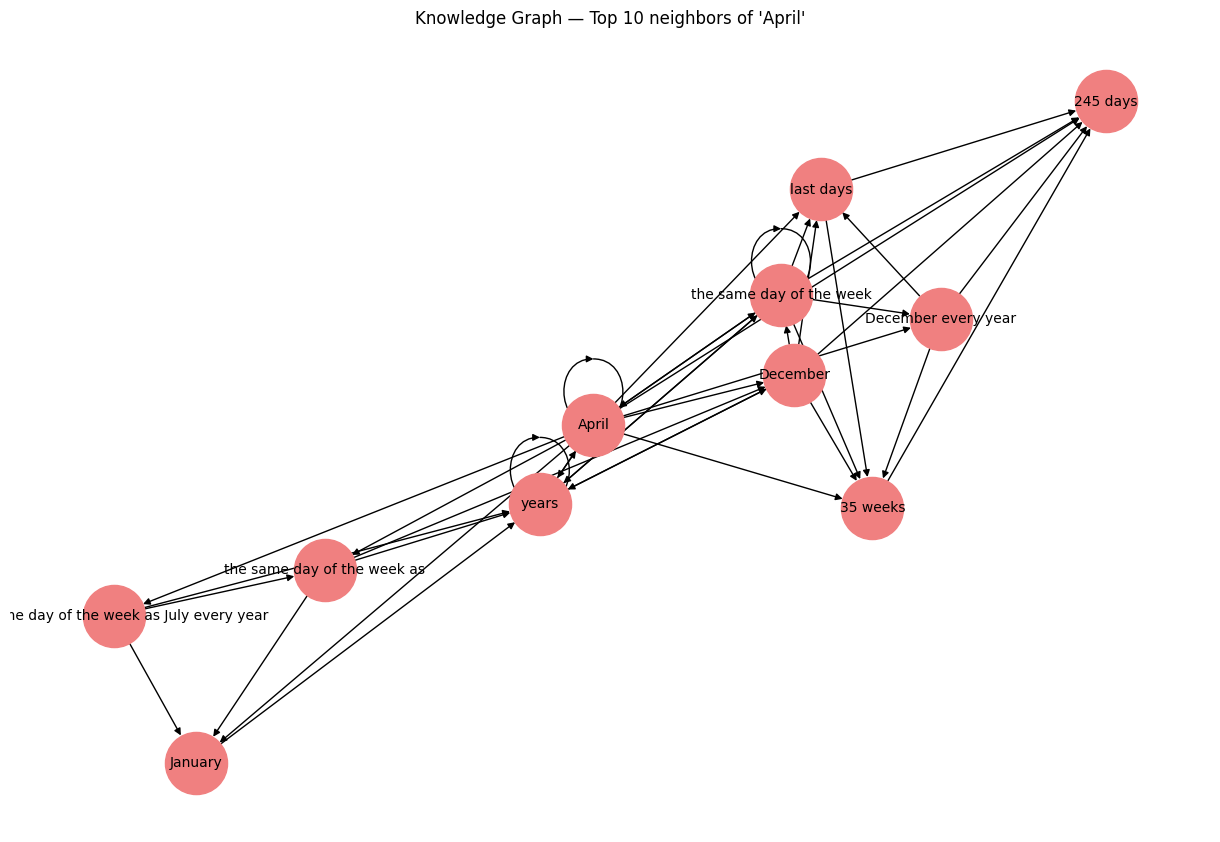

In [19]:
target = "April"
max_neighbors = 10

if target not in G:
    print(f"'{target}' not found in KG.")
else:
    neighbors = list(G.neighbors(target))[:max_neighbors]

    sub_nodes = [target] + neighbors
    subgraph = G.subgraph(sub_nodes)

    plt.figure(figsize=(12, 8))
    nx.draw(
        subgraph,
        with_labels=True,
        node_color='lightcoral',
        node_size=2000,
        font_size=10
    )
    plt.title(f"Knowledge Graph — Top {max_neighbors} neighbors of '{target}'")
    plt.show()


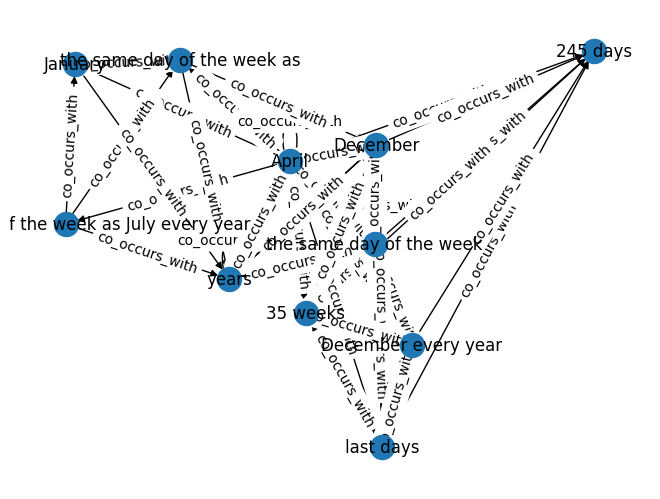

In [20]:
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True)
edge_labels = nx.get_edge_attributes(subgraph, "label")
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)
plt.show()
